# Ray et al 2013 Benchmarking 
**Authorship:**
Adam Klie, *09/03/2022*
***
**Description:**
Notebook to benchmark MT and ST models against trained DeepBind models
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import keras as K
import tensorflow as tf
import numpy as np
import pandas as pd
import eugene as eu
import kipoi

2022-09-04 21:35:32.505212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-04 21:35:32.505261: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Global seed set to 13
/workspaces/EUGENe/eugene/external/kipoi_veff/seqplotting_deps.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/workspaces/EUGENe/eugene/external/kipoi_veff/seqplotting_deps.py:37: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of N

Already up to date.


In [2]:
eu.settings.dataset_dir = "../../../_datasets/ray13"
eu.settings.output_dir = "../../../_output/ray13"
eu.settings.logging_dir = "../../../_logs/ray13"
eu.settings.config_dir = "../../../_configs/ray13"
figure_dir = "../../../_figures/ray13"
eu.settings.verbosity = logging.ERROR

# Load the test data with our trained DeepBind predictions

In [3]:
# Load the sdata and grab the target cols that aren't prediction columns
sdata_test = eu.dl.read_h5sd(os.path.join(eu.settings.output_dir, "norm_test_predictions.h5sd"))
target_mask = sdata_test.seqs_annot.columns.str.contains("RNCMPT") & ~sdata_test.seqs_annot.columns.str.contains("MT|ST")
target_cols = sdata_test.seqs_annot.columns[target_mask]

In [4]:
# We also need the presence/absence matrix to evaluate kipoi models
b_presence_absence = np.load(os.path.join(eu.settings.dataset_dir, "SetB_binary.npy"))
setB_observed = sdata_test.seqs_annot[target_cols]

In [5]:
# We need to get the protein IDs from the motifs in the
id_mapping = pd.read_excel(os.path.join(eu.settings.dataset_dir, "ID.mapping.xls"), sheet_name=0)
id_mp = id_mapping.set_index("Motif ID")["Protein(s)"]
cols_w_ids = ~target_cols.map(id_mp).isna()
target_cols_w_ids = target_cols[cols_w_ids]
ids_w_target_cols = pd.Index([id.split("(")[0].rstrip() for id in target_cols_w_ids.map(id_mp)])

In [6]:
# Get the kipoi models names
db_model_names = eu.external.kipoi.get_model_names("DeepBind/Homo_sapiens/RBP/D")

In [7]:
# Get predictions with each model and store them in sdata
target_cols_w_model = []
for i, (protein_id , motif_id) in tqdm(enumerate(zip(ids_w_target_cols, target_cols_w_ids)), desc="Importing models", total=len(ids_w_target_cols)):
    print("Predicting for protein: ", protein_id, " motif: ", motif_id)
    db_model_name = db_model_names[db_model_names.str.contains(protein_id)]
    if len(db_model_name) == 0:
        print("No model found for protein: ", protein_id)
        continue
    try:
        model = eu.external.kipoi.get_model(db_model_name.values[0])
        sdata_test[f"{motif_id}_predictions_kipoi"] = model(sdata_test.ohe_seqs)
        target_cols_w_model.append(motif_id)
    except:
        print("Failed to load model")
    if len(target_cols_w_model) == 5:
        break

Importing models:   0%|          | 0/131 [00:00<?, ?it/s]

Predicting for protein:  A1CF  motif:  RNCMPT00001
Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF/arch/127f7597630be937c0495a27e6f42e5f
Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF/weights/a4caf255312f44e3fd4e038a79691f2d


2022-09-04 21:36:40.101441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-04 21:36:40.115850: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-04 21:36:40.133203: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-c1a1c0): /proc/driver/nvidia/version does not exist
2022-09-04 21:36:40.171362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-04 21:36:40.951570: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /hom

Predicting for protein:  ANKHD1  motif:  RNCMPT00002
Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00085.001_RNAcompete_ANKHD1/arch/4b6baf31fd2bcad82c936a536bea804c
Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00085.001_RNAcompete_ANKHD1/weights/488b315616bdfaf723ea431bce2df302


2022-09-04 21:36:43.053817: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00085.001_RNAcompete_ANKHD1/weights/488b315616bdfaf723ea431bce2df302: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?
2022-09-04 21:36:43.211101: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00201.001_RNAcompete_CNOT4/weights/cc7c64aa43e265a965b765db2cc044fe: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  CELF4  motif:  RNCMPT00004
No model found for protein:  CELF4
Predicting for protein:  CNOT4  motif:  RNCMPT00008
Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00201.001_RNAcompete_CNOT4/arch/367bfbfebbe3deccfcee7247a6cf9de9
Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00201.001_RNAcompete_CNOT4/weights/cc7c64aa43e265a965b765db2cc044fe
Predicting for protein:  CPEB2  motif:  RNCMPT00012
Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00095.001_RNAcompete_CPEB2/arch/c6a22ad58256249558a0de864debded3
Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00095.001_RNAcompete_CPEB2/weights/dcfd4dd20b889cb98443a2b84f4dee99


2022-09-04 21:36:43.368578: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00095.001_RNAcompete_CPEB2/weights/dcfd4dd20b889cb98443a2b84f4dee99: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  DAZAP1  motif:  RNCMPT00013
Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00096.001_RNAcompete_DAZAP1/arch/9d0289f968d184b4b4b11608c72b29ae
Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00096.001_RNAcompete_DAZAP1/weights/d5c4ab8e15825ceffb2eb928faf82c2e


2022-09-04 21:36:43.612161: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00096.001_RNAcompete_DAZAP1/weights/d5c4ab8e15825ceffb2eb928faf82c2e: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


In [19]:
# Save the sdata with kipoi predictions
sdata_test.write_h5sd(os.path.join(eu.settings.output_dir, "norm_test_predictions.h5sd"))

In [8]:
# Evaluate the predictions using the RNAcompete metrics
pearson_kipoi_df, spearman_kipoi_df = eu.predict.summarize_rbps_apply(sdata_test, b_presence_absence, target_cols_w_model, use_calc_auc=True, verbose=False, n_kmers=100, preds_suffix="_predictions_kipoi")
pearson_kipoi_long = pearson_kipoi_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_kipoi_long = spearman_kipoi_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)
pearson_kipoi_long["Model"] = "Kipoi"
spearman_kipoi_long["Model"] = "Kipoi"

Evaluating probes:   0%|          | 0/5 [00:00<?, ?it/s]

/home/vscode/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vscode/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/vscode/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/vscode/.local/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/vscode/.local/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


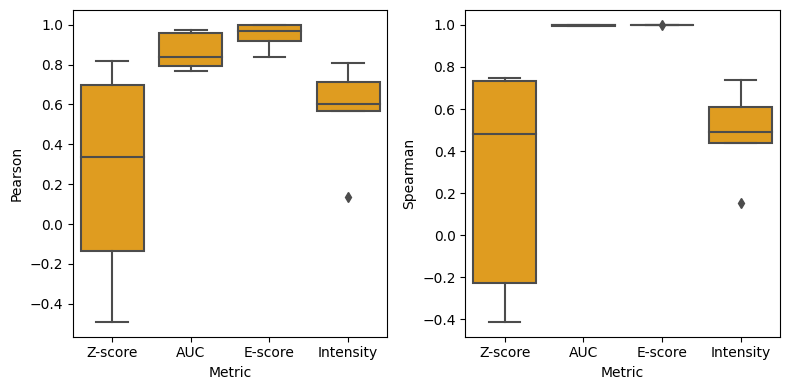

In [9]:
# Plot just the kipoi results as boxplots
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_kipoi_long, x="Metric", y="Pearson", color="orange", ax=ax[0])
sns.boxplot(data=spearman_kipoi_long, x="Metric", y="Spearman", color="orange", ax=ax[1])
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, "correlation_boxplots_kipoi.pdf"))


# Benchmarking plots

In [10]:
# For plotting comparisons to kipoi we need to get only the shared columns
share_target_cols = []
for col in target_cols:
    if f"{col}_predictions_kipoi" in sdata_test.seqs_annot.columns and f"{col}_predictions_MT" in sdata_test.seqs_annot.columns and f"{col}_predictions_ST" in sdata_test.seqs_annot.columns:
        share_target_cols.append(col)

In [11]:
# (Re)evaluate the singletask predictions using the RNAcompete metrics
pearson_ST_df, spearman_ST_df = eu.predict.summarize_rbps_apply(sdata_test, b_presence_absence, share_target_cols, use_calc_auc=True, verbose=False, n_kmers=100, preds_suffix="_predictions_ST")
pearson_ST_long = pearson_ST_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_ST_long = spearman_ST_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)
pearson_ST_long["Model"] = "SingleTask"
spearman_ST_long["Model"] = "SingleTask"

Evaluating probes:   0%|          | 0/2 [00:00<?, ?it/s]

/home/vscode/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vscode/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
# (Re)evaluate the multitask predictions using the RNAcompete metrics
pearson_MT_df, spearman_MT_df = eu.predict.summarize_rbps_apply(sdata_test, b_presence_absence, share_target_cols, use_calc_auc=True, verbose=False, n_kmers=100, preds_suffix="_predictions_MT")
pearson_MT_long = pearson_MT_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_MT_long = spearman_MT_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)
pearson_MT_long["Model"] = "MultiTask"
spearman_MT_long["Model"] = "MultiTask"

Evaluating probes:   0%|          | 0/2 [00:00<?, ?it/s]

## Evaluation metric boxplots

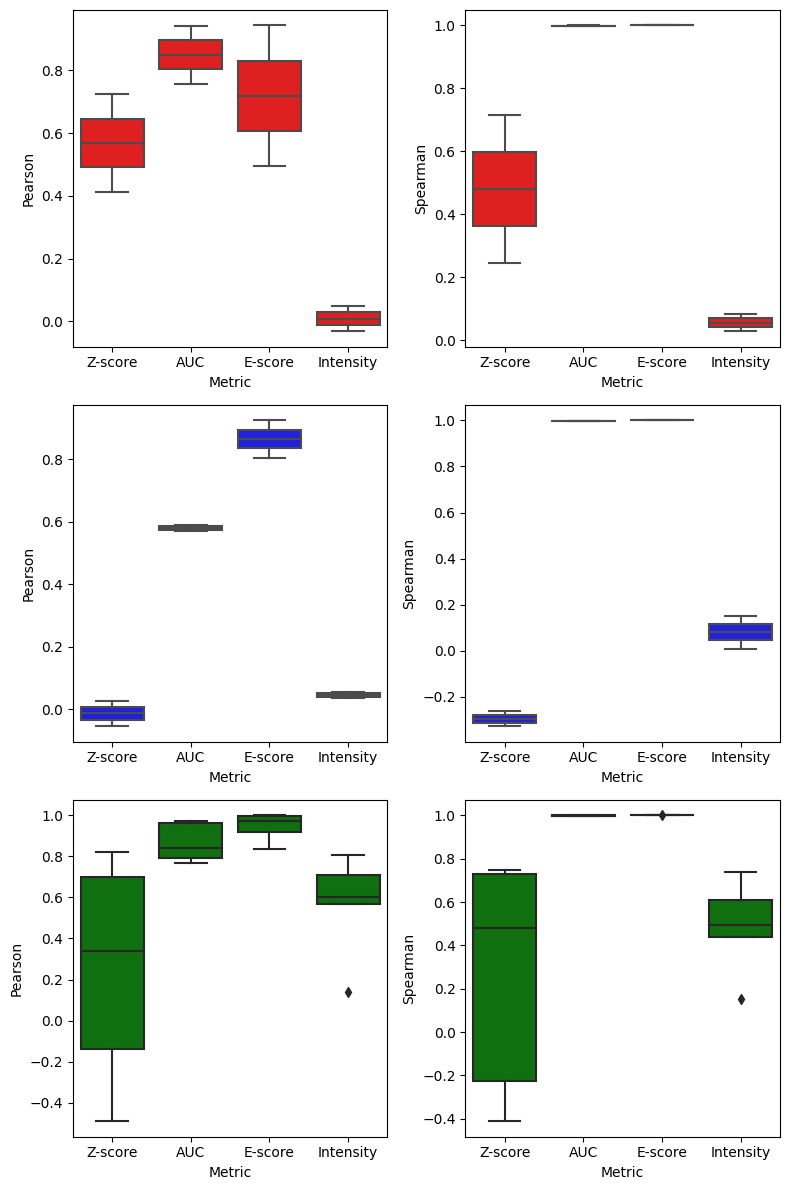

In [13]:
# Just for fun, let's also plot boxplots for all of them
fig, ax = plt.subplots(3, 2, figsize=(8, 12))
sns.boxplot(data=pearson_ST_long, x="Metric", y="Pearson", color="red", ax=ax[0][0])
sns.boxplot(data=spearman_ST_long, x="Metric", y="Spearman", color="red", ax=ax[0][1])
sns.boxplot(data=pearson_MT_long, x="Metric", y="Pearson", color="blue", ax=ax[1][0])
sns.boxplot(data=spearman_MT_long, x="Metric", y="Spearman", color="blue", ax=ax[1][1])
sns.boxplot(data=pearson_kipoi_long, x="Metric", y="Pearson", color="green", ax=ax[2][0])
sns.boxplot(data=spearman_kipoi_long, x="Metric", y="Spearman", color="green", ax=ax[2][1])
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, "correlation_boxplots.pdf"))

## Comparison scatterplots

In [14]:
# Concatenate the dataframes
from eugene.plotting import const_line
pearson_long = pd.concat([pearson_ST_long, pearson_MT_long, pearson_kipoi_long])
spearman_long = pd.concat([spearman_ST_long, spearman_MT_long, spearman_kipoi_long])
pearson_models = pearson_long.pivot(index=["RBP", "Metric"], columns="Model", values="Pearson").reset_index()
spearman_models = spearman_long.pivot(index=["RBP", "Metric"], columns="Model", values="Spearman").reset_index()

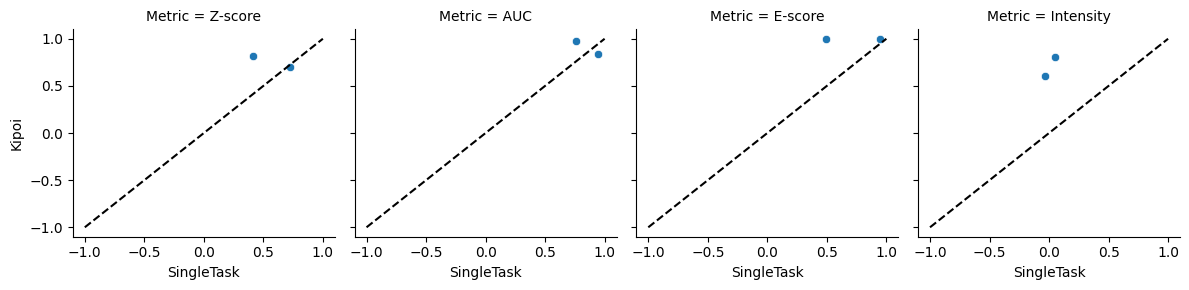

In [15]:
# Plot the Pearson correlations comparisons between single task vs kipoi
g = sns.FacetGrid(pearson_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "Kipoi")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_ST_kipoi.pdf"))

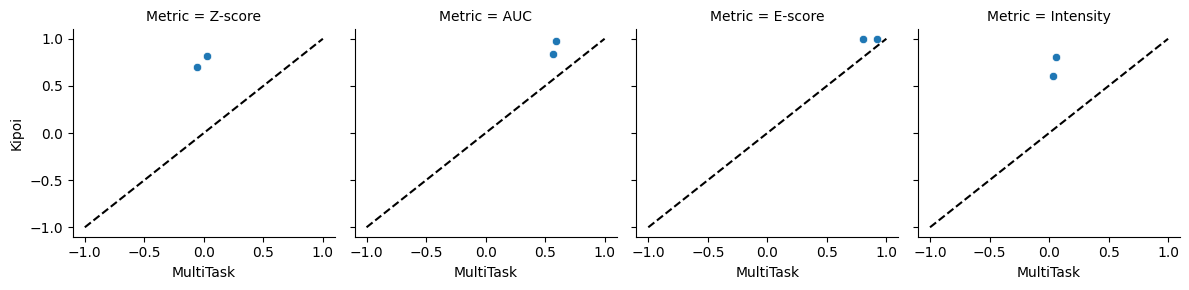

In [16]:
# Plot the Pearson correlations comparisons between multitask vs kipoi
g = sns.FacetGrid(pearson_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "MultiTask", "Kipoi")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_MT_kipoi.pdf"))

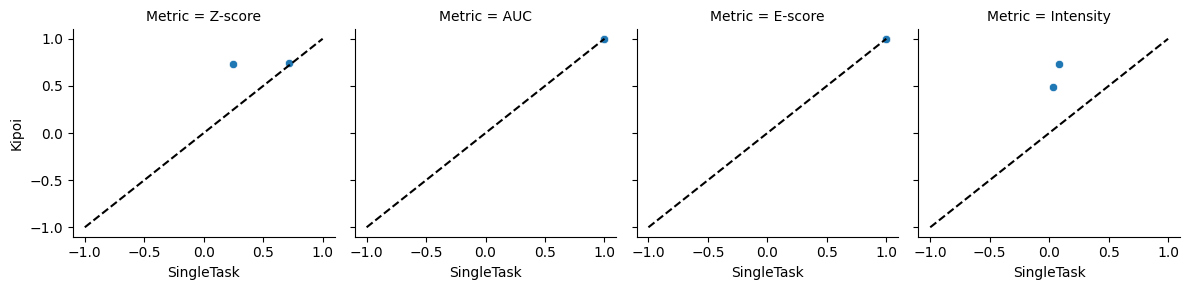

In [17]:
# Plot the Spearman correlations comparisons between single task vs kipoi
g = sns.FacetGrid(spearman_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "Kipoi")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_spearman_scatterplot_comparisons_ST_kipoi.pdf"))

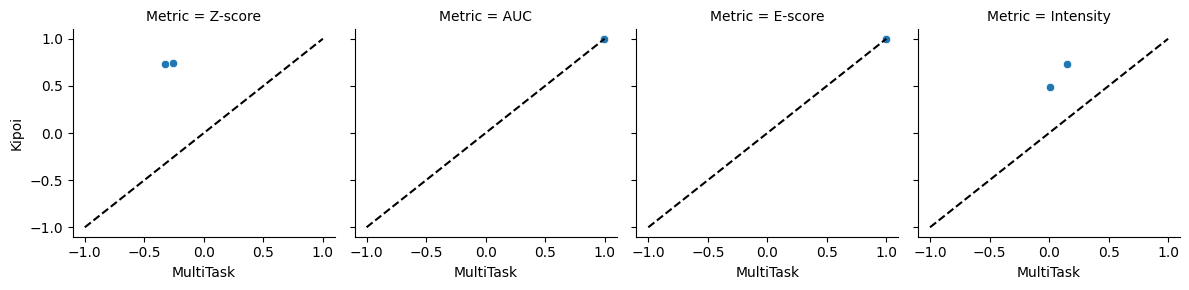

In [18]:
# Plot the Spearman correlations comparisons between multitask vs kipoi
g = sns.FacetGrid(spearman_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "MultiTask", "Kipoi")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_spearman_scatterplot_comparisons_MT_kipoi.pdf"))

---

# Scratch 

In [47]:
model = kipoi.get_model('DeepBind/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF').model
model.summary()

Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF/arch/127f7597630be937c0495a27e6f42e5f
Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF/weights/a4caf255312f44e3fd4e038a79691f2d
Model: "model_94"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_94 (InputLayer)          [(None, None, 4)]    0           []                               
                                                                                                  
 lambda_276 (Lambda)            (None, None, 4)      0           ['input_94[0][0]']               
                                                                                                  
 conv1d_94 (Conv1D)            

2022-09-04 00:29:07.587119: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF/weights/a4caf255312f44e3fd4e038a79691f2d: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


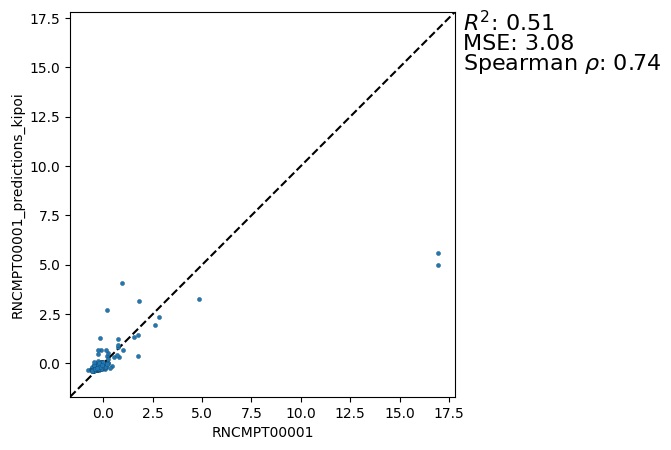

In [31]:
eu.pl.performance_scatter(
    sdata_test,
    target_cols[0],
    f"{target_cols[0]}_predictions_kipoi",
    figsize=(5, 5),
)

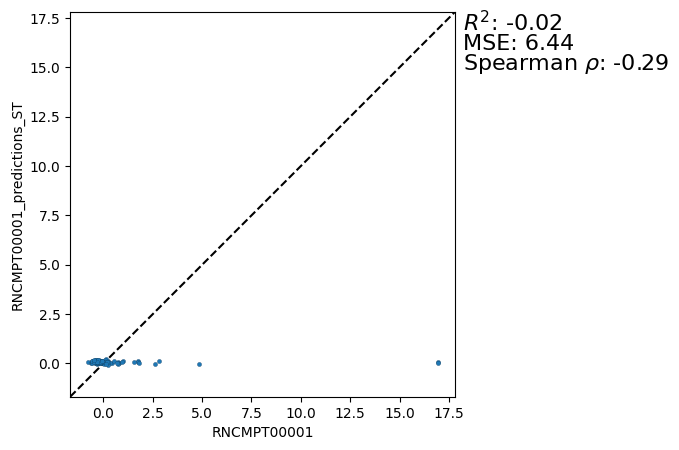

In [34]:
eu.pl.performance_scatter(
    sdata_test,
    target_cols[0],
    f"{target_cols[0]}_predictions_ST",
    figsize=(5, 5),
)

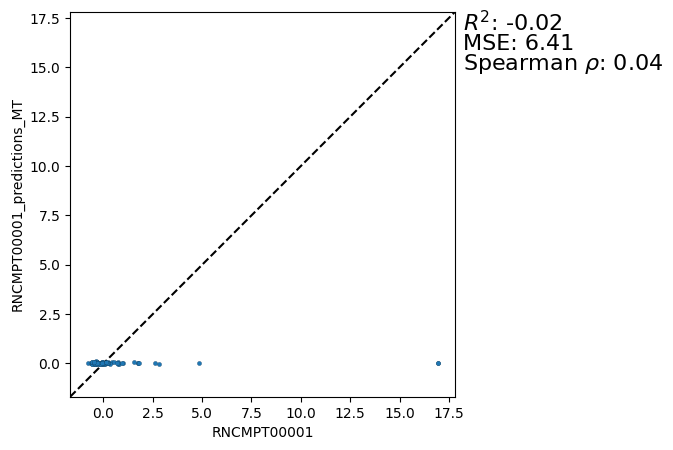

In [33]:
eu.pl.performance_scatter(
    sdata_test,
    target_cols[0],
    f"{target_cols[0]}_predictions_MT",
    figsize=(5, 5),
)

In [29]:
sdata_test

SeqData object with = 100 seqs
seqs = (100,)
names = (100,)
rev_seqs = None
ohe_seqs = (100, 41, 4)
ohe_rev_seqs = None
seqs_annot: 'Probe_Set', 'RNCMPT00001', 'RNCMPT00001_predictions_MT', 'RNCMPT00001_predictions_ST', 'RNCMPT00002', 'RNCMPT00002_predictions_MT', 'RNCMPT00002_predictions_ST', 'RNCMPT00003', 'RNCMPT00003_predictions_MT', 'RNCMPT00003_predictions_ST', 'RNCMPT00004', 'RNCMPT00004_predictions_MT', 'RNCMPT00004_predictions_ST', 'RNCMPT00005', 'RNCMPT00005_predictions_MT', 'RNCMPT00005_predictions_ST', 'RNCMPT00006', 'RNCMPT00006_predictions_MT', 'RNCMPT00007', 'RNCMPT00007_predictions_MT', 'RNCMPT00008', 'RNCMPT00009', 'RNCMPT00010', 'RNCMPT00010_predictions_MT', 'RNCMPT00011', 'RNCMPT00011_predictions_MT', 'RNCMPT00012', 'RNCMPT00012_predictions_MT', 'RNCMPT00013', 'RNCMPT00013_predictions_MT', 'RNCMPT00014', 'RNCMPT00014_predictions_MT', 'RNCMPT00015', 'RNCMPT00016', 'RNCMPT00016_predictions_MT', 'RNCMPT00017', 'RNCMPT00017_predictions_MT', 'RNCMPT00018', 'RNCMPT00018_pr

In [24]:
sdata_test["RNCMPT00001"].values

array([-3.27493065e-01, -3.42261224e-01,  1.93591734e-01,  1.73070340e+00,
       -8.22276870e-02, -3.87272678e-03, -8.00605627e-01,  7.51865532e-01,
       -1.84364492e-02, -1.90977154e-01, -6.11971428e-01,  1.69336841e+01,
       -1.50286938e-01,  4.15017634e-01, -3.44858715e-01,  8.02916737e-01,
       -8.69724004e-02, -2.55419595e-01,  2.21111708e-01, -2.52743450e-01,
        9.75111618e-01, -5.56894859e-01,  2.17765571e-01,  9.40233517e-01,
       -1.17495874e-01, -2.20792741e-01, -3.07698375e-01, -3.35112310e-01,
                   nan,  2.80191096e+00, -4.30429143e-01,  1.73595124e+00,
       -4.14881768e-01,  1.30148548e-01, -3.21330673e-02, -2.34298934e-01,
       -4.13446572e-01,  2.53961042e-02,  1.54145652e-01, -3.14702400e-01,
       -3.93914593e-01,  1.26059497e-01, -5.08499739e-01, -5.71038245e-01,
       -1.16288360e-01, -3.65702018e-01,  5.31071407e-02,  3.11713442e-01,
       -4.44369047e-01,  7.26077537e-01, -5.90690279e-02, -4.74033695e-01,
        5.54652000e-01, -